# Combines models from Julia and Lukas

In [6]:
import os
import pathlib
import yaml
from networks.unetHalfPad import UNetHalfPad
from networks.pinn import SVDPINN_one_extension
from data_stuff.dataset import SimulationDataset
from data_stuff.transforms import NormalizeTransform, SignedDistanceTransform
from utils.visualization import prepare_data_to_plot, plot_datafields
from copy import deepcopy
import matplotlib.pyplot as plt
import torch

Settings

In [7]:
datset_name = "Julia_datset_visualize"
number_iterations = 6

julia_model_name = "lukas model gksi 64_256"
lukas_model_name = "e_iterative_1"

device = "cpu"

Load paths

In [8]:
paths_file = "paths.yaml"
if not os.path.exists(paths_file):
    raise FileNotFoundError(f"{paths_file} not found")

with open(paths_file, "r") as f:
    paths = yaml.safe_load(f)

Load dataset and models

In [9]:
datasets_prepared_dir = pathlib.Path(paths["datasets_prepared_dir"])

dataset = SimulationDataset(datasets_prepared_dir / datset_name)

destination_dir = pathlib.Path(paths["models_1hp_dir"])

julia_model_dir = destination_dir / julia_model_name
julia_model = UNetHalfPad(in_channels=4).float()
julia_model.load(julia_model_dir, device)
julia_model.eval()
with open(julia_model_dir / "info.yaml", "r") as f:
    julia_info = yaml.safe_load(f)
julia_norm = NormalizeTransform(julia_info)

lukas_model_dir = destination_dir / lukas_model_name
lukas_model = SVDPINN_one_extension(dataset = dataset, device = device, number_iterations=number_iterations, num_sing_values=50).float()
lukas_model.load(lukas_model_dir, device)
lukas_model.eval()
lukas_model.U = lukas_model.U.to(device)
with open(lukas_model_dir / "info.yaml", "r") as f:
    lukas_info = yaml.safe_load(f)
lukas_norm = NormalizeTransform(lukas_info)

sdf_transform = SignedDistanceTransform()

Visualize

Julia output:


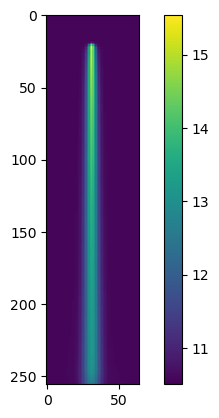

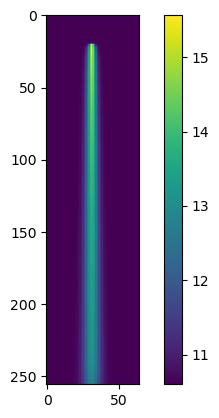

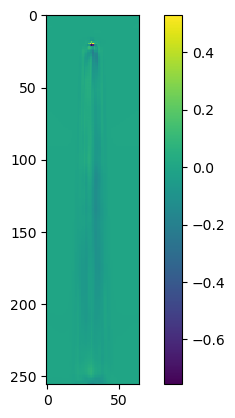

Lukas output with true as input:
torch.Size([3, 128, 64]) torch.Size([2, 896, 64]) torch.Size([2, 896, 64])
[5.0, 5.0] torch.Size([128, 64])
Lukas output with Julia output as input:
[5.0, 5.0] torch.Size([128, 64])
Julia output:


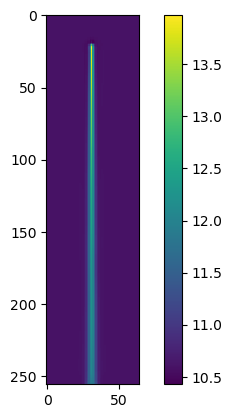

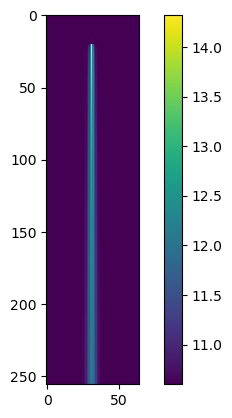

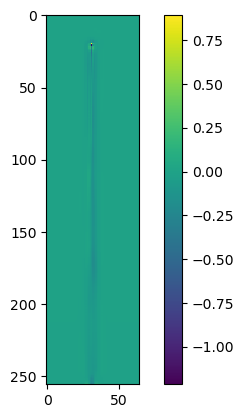

Lukas output with true as input:
torch.Size([3, 128, 64]) torch.Size([2, 896, 64]) torch.Size([2, 896, 64])
[5.0, 5.0] torch.Size([128, 64])
Lukas output with Julia output as input:
[5.0, 5.0] torch.Size([128, 64])
Julia output:


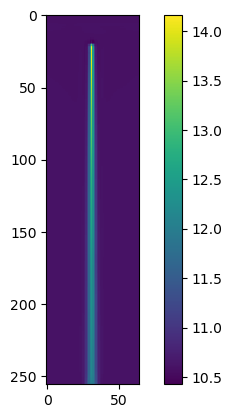

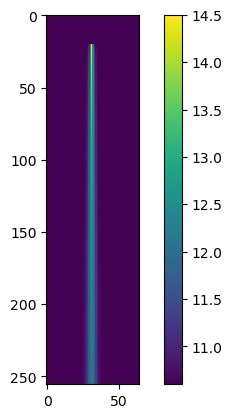

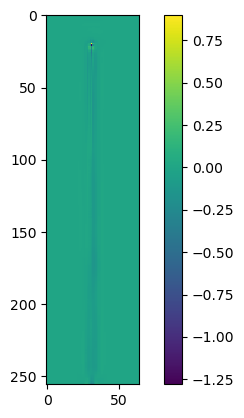

Lukas output with true as input:
torch.Size([3, 128, 64]) torch.Size([2, 896, 64]) torch.Size([2, 896, 64])
[5.0, 5.0] torch.Size([128, 64])
Lukas output with Julia output as input:
[5.0, 5.0] torch.Size([128, 64])
Julia output:


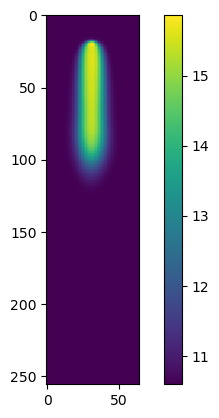

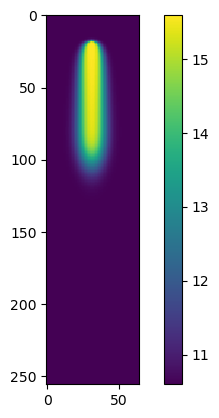

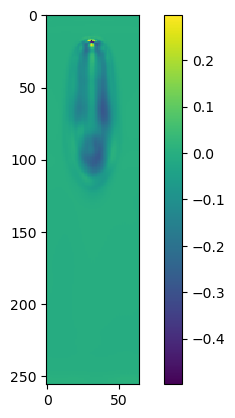

Lukas output with true as input:
torch.Size([3, 128, 64]) torch.Size([2, 896, 64]) torch.Size([2, 896, 64])
[5.0, 5.0] torch.Size([128, 64])
Lukas output with Julia output as input:
[5.0, 5.0] torch.Size([128, 64])
Julia output:


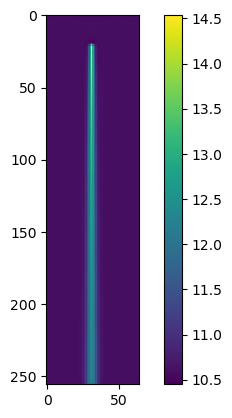

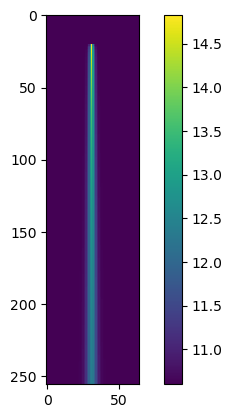

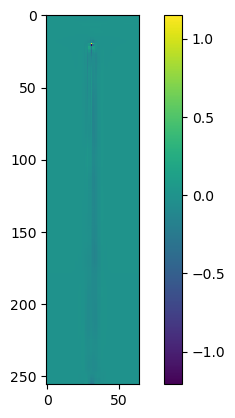

Lukas output with true as input:
torch.Size([3, 128, 64]) torch.Size([2, 896, 64]) torch.Size([2, 896, 64])
[5.0, 5.0] torch.Size([128, 64])
Lukas output with Julia output as input:
[5.0, 5.0] torch.Size([128, 64])
Julia output:


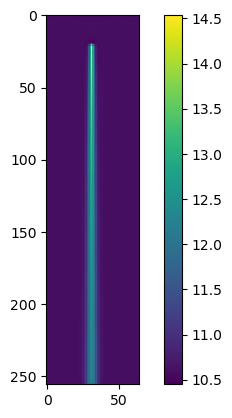

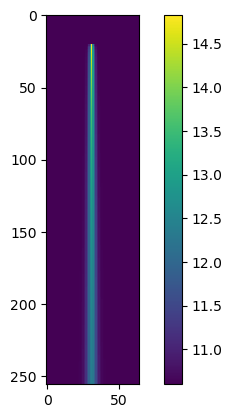

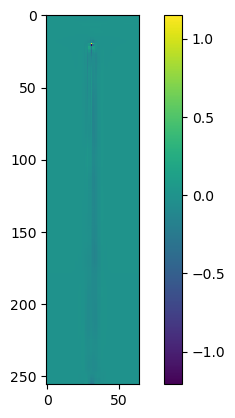

Lukas output with true as input:
torch.Size([3, 128, 64]) torch.Size([2, 896, 64]) torch.Size([2, 896, 64])
[5.0, 5.0] torch.Size([128, 64])
Lukas output with Julia output as input:
[5.0, 5.0] torch.Size([128, 64])
Julia output:


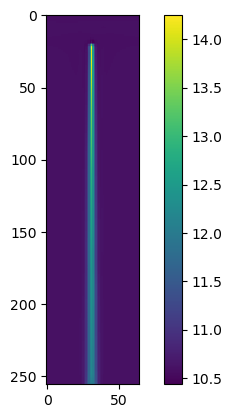

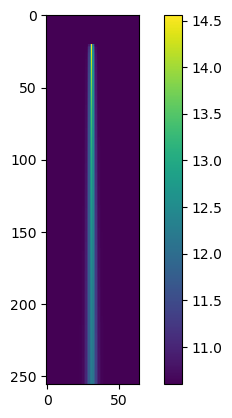

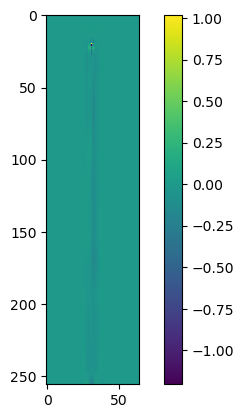

Lukas output with true as input:
torch.Size([3, 128, 64]) torch.Size([2, 896, 64]) torch.Size([2, 896, 64])
[5.0, 5.0] torch.Size([128, 64])
Lukas output with Julia output as input:
[5.0, 5.0] torch.Size([128, 64])


IndexError: list index out of range

In [11]:
lower_bound = 0 if dataset[0][0].shape[2] == 64 else 32
upper_bound = 64 if dataset[0][0].shape[2] == 64 else 96

info = deepcopy(dataset.info)
info["Inputs"].pop("Material ID")
info["Inputs"].pop("SDF")
info["Inputs"]["Permeability X [m^2]"]["index"] = 2
info["Inputs"]["Pressure Gradient [-]"]["index"] = 1
info["Inputs"]["Temperature [C]"] = info["Labels"]["Temperature [C]"]
settings_pic = {"format": "png",
                "dpi": 600,}

for i in range(12):
    input, label = dataset[i]
    input = dataset.norm.reverse(input, "Inputs")
    label = dataset.norm.reverse(label, "Labels")
    input = input[: , :256, lower_bound:upper_bound]
    input[2] = sdf_transform.sdf(input[2], torch.tensor([21, 31]))
    label = label[: , :128*(number_iterations+2), lower_bound:upper_bound]

    julia_input = julia_norm(input.clone()).unsqueeze(0)
    julia_output = julia_model(julia_input).detach()
    julia_output = julia_norm.reverse(julia_output, "Labels").squeeze()

    lukas_input_unnorm = torch.cat((julia_output[128:256].unsqueeze(0), input[0:2, 128:256].clone()), dim=0)
    lukas_input = lukas_norm(lukas_input_unnorm.clone()).unsqueeze(0)
    lukas_output = lukas_model(lukas_input).detach().squeeze()
    lukas_output = lukas_norm.reverse(lukas_output, "Labels").squeeze()

    combined_output = torch.cat((julia_output[0:128], lukas_output[0]), dim=0)

    lukas_input_true_unnorm = torch.cat((label[0, 128:256].unsqueeze(0), input[0:2, 128:256].clone()), dim=0)
    lukas_input_true = lukas_norm(lukas_input_true_unnorm.clone()).unsqueeze(0)
    lukas_output_true = lukas_model(lukas_input_true).detach().squeeze()
    lukas_output_true = lukas_norm.reverse(lukas_output_true, "Labels").squeeze()

    combined_output_true = torch.cat((label[0, 0:128], lukas_output_true[0]), dim=0)

    print("Julia output:")
    plt.imshow(julia_output)
    plt.colorbar()
    plt.show()
    plt.imshow(label[0, :256])
    plt.colorbar()
    plt.show()
    plt.imshow(julia_output - label[0, :256])
    plt.colorbar()
    plt.show()

    print("Lukas output with true as input:")
    print(lukas_input_true_unnorm.shape, label[:, 128:].shape, lukas_output_true.shape)
    dict_to_plot = prepare_data_to_plot(lukas_input_true_unnorm.clone(), label[:, 256:].clone(), lukas_output_true[:, 128:].clone(), info)
    plot_datafields(dict_to_plot, str(i) + "_Output_with_truth", settings_pic)
    torch.save(lukas_output_true, str(i) + "_Output_with_truth.pt")
    plt.close("all")

    # plt.imshow(combined_output_true)
    # plt.colorbar()
    # plt.show()
    # plt.imshow(label[0])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(combined_output_true[256:] - label[0, 256:])
    # plt.colorbar()
    # plt.show()


    print("Lukas output with Julia output as input:")
    dict_to_plot = prepare_data_to_plot(lukas_input_unnorm.clone(), label[:, 256:].clone(), lukas_output[:, 128:].clone(), info)
    plot_datafields(dict_to_plot, str(i) + "_Output_with_CNN", settings_pic)
    torch.save(lukas_output, str(i) + "_Output_with_CNN.pt")
    plt.close("all")
    

    # plt.imshow(combined_output)
    # plt.colorbar()
    # plt.show()
    # plt.imshow(label[0])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(combined_output[256:] - label[0, 256:])
    # plt.colorbar()
    # plt.show()

